Predicting Runs Scored - The First Model

    - We will now use the data frame from before to build a model to predict the distribution of runs scored

    - We will use an algorithm called Coarsage to model these distributions (Coarsage is in the StructureBoost package)

    - Coarsage is similar to PrestoBoost (a paper on PrestoBoost can be found here: https://arxiv.org/abs/2210.16247)

    - But it is a bit cleaner (needs only a single forest)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import structureboost as stb
import ml_insights as mli

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
# need to have StructureBoost >= 0.4.0

stb.__version__

'0.4.3'

In [3]:
df = pd.read_csv('df_bp9.csv', low_memory=False)

df_runs = pd.read_csv('df_runs_bp11.csv', low_memory=False)

In [4]:
df.over_under_line.max()

19.5

In [5]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],20)

In [6]:
df_train = df_runs[(df_runs.season>2000) & (df_runs.season<=2015) & ~(df_runs.OBP_162.isnull())]
df_valid = df_runs[(df_runs.season>=2016) & (df_runs.season<=2020)]
df_test = df_runs[df_runs.season>=2021]

In [7]:
df_test_game = df[df.season>=2021]

BEGIN MODELING

In [8]:
df_runs.head(10)

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_10,lineup9_BATAVG_10,lineup8_BATAVG_10_w,lineup9_BATAVG_10_w,lineup8_OBP_10,lineup9_OBP_10,lineup8_OBP_10_w,lineup9_OBP_10_w,lineup8_SLG_10,lineup9_SLG_10,lineup8_SLG_10_w,lineup9_SLG_10_w,lineup8_OBS_10,lineup9_OBS_10,lineup8_OBS_10_w,lineup9_OBS_10_w,lineup8_SLGmod_10,lineup9_SLGmod_10,lineup8_SLGmod_10_w,lineup9_SLGmod_10_w,lineup8_SObat_perc_10,lineup9_SObat_perc_10,lineup8_SObat_perc_10_w,lineup9_SObat_perc_10_w,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_81,lineup9_BATAVG_81,lineup8_BATAVG_81_w,lineup9_BATAVG_81_w,lineup8_OBP_81,lineup9_OBP_81,lineup8_OBP_81_w,lineup9_OBP_81_w,lineup8_SLG_81,lineup9_SLG_81,lineup8_SLG_81_w,lineup9_SLG_81_w,lineup8_OBS_81,lineup9_OBS_81,lineup8_OBS_81_w,lineup9_OBS_81_w,lineup8_SLGmod_81,lineup9_SLGmod_81,lineup8_SLGmod_81_w,lineup9_SLGmod_81_w,lineup8_SObat_perc_81,lineup9_SObat_perc_81,lineup8_SObat_perc_81_w,lineup9_SObat_perc_81_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,Strt_ERA_6,Strt_WHIP_6,Strt_SO_perc_6,Strt_H_BB_perc_6,Strt_TB_BB_perc_6,Strt_FIP_6,Strt_FIP_perc_6,Strt_ERA_15,Strt_WHIP_15,Strt_SO_perc_15,Strt_H_BB_perc_15,Strt_TB_BB_perc_15,Strt_FIP_15,Strt_FIP_perc_15,Strt_ERA_30,Strt_WHIP_30,Strt_SO_perc_30,Strt_H_BB_perc_30,Strt_TB_BB_perc_30,Strt_FIP_30,Strt_FIP_perc_30,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_30,Bpen_SO_perc_30,Bpen_H_BB_perc_30,Bpen_TB_BB_perc_30,Bpen_WHIP_162,Bpen_SO_perc_162,Bpen_H_BB_perc_162,Bpen_TB_BB_perc_162,home_hitting,runs_trunc
0,2000,20000329,0,200003290,NYN,CHN,NL,NL,0.0,NaN,TOK01,N,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237860,0.251431,0.238568,0.250346,0.334452,0.344910,0.334292,0.343436,0.382455,0.384404,0.381870,0.383628,0.716907,0.729314,0.716162,0.727065,0.402844,0.389830,0.399184,0.388178,0.147286,0.146794,0.145588,0.145323,0.245549,0.254750,0.246067,0.254049,0.346180,0.352160,0.347118,0.352248,0.389000,0.397188,0.389727,0.396804,0.735181,0.749348,0.736845,0.749051,0.408938,0.412390,0.409787,0.412717,0.151145,0.158055,0.151315,0.157331,0.294249,0.291099,0.296043,0.293119,0.373477,0.369210,0.375677,0.371739,0.461612,0.448858,0.464532,0.453115,0.835089,0.818068,0.840209,0.824854,0.399125,0.396081,0.400460,0.397673,0.137912,0.145276,0.137494,0.143963,0.293784,0.283775,0.294884,0.286040,0.371615,0.363083,0.373521,0.365888,0.459983,0.437337,0.461734,0.441796,0.831597,0.800420,0.835255,0.807684,0.396236,0.394088,0.397373,0.395387,0.137939,0.148280,0.137354,0.146438,3.941606,0.919708,0.275862,0.241379,0.402299,2.364964,0.620690,4.942373,1.250847,0.243373,0.296386,0.472289,3.945763,0.934940,4.192833,1.366894,0.212515,0.315230,0.460449,4.121160,0.950413,1.50,0.200000,0.370000,0.450000,1.500000,0.200000,0.370000,0.450000,1.500000,0.200000,0.370000,0.450000,1,3
1,2000,20000330,0,200003300,CHN,NYN,NL,NL,0.0,NaN,TOK01,N,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.255689,0.238390,0.254898,0.239873,0.348563,0.332056,0.34

In [9]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_15',
 'Strt_TB_BB_perc_15',
 'Strt_H_BB_perc_15',
 'Strt_SO_perc_6',
 'Bpen_WHIP_162',
 'Bpen_TB_BB_perc_162',
 'Bpen_H_BB_perc_162',
 'Bpen_SO_perc_162',
 'Bpen_WHIP_30',
 'Bpen_TB_BB_perc_30',
 'Bpen_H_BB_perc_30',
 'Bpen_SO_perc_30',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']

In [17]:
bpv2 = np.linspace(-.5,19.5,21)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5])

In [19]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [20]:
cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.50039577154714


i=10, eval_set_loss = 2.4976989221147594
i=20, eval_set_loss = 2.4956939033551255
i=30, eval_set_loss = 2.4943175717470494
i=40, eval_set_loss = 2.493290017076739
i=50, eval_set_loss = 2.4924240272444442
i=60, eval_set_loss = 2.491763676879006
i=70, eval_set_loss = 2.491365710571542
i=80, eval_set_loss = 2.490822974696586
i=90, eval_set_loss = 2.49041267179445
i=100, eval_set_loss = 2.490166513743733
i=110, eval_set_loss = 2.4899580512502277
i=120, eval_set_loss = 2.489860040077098
i=130, eval_set_loss = 2.4898160094873307
i=140, eval_set_loss = 2.489695444114897
i=150, eval_set_loss = 2.4897232641807583
i=160, eval_set_loss = 2.4896907844686087
i=170, eval_set_loss = 2.489666028050559
i=180, eval_set_loss = 2.489609402894523
i=190, eval_set_loss = 2.48959485774995
i=200, eval_set_loss = 2.489634791972928
i=210, eval_set_loss = 2.489700307239888
i=220, eval_set_loss = 2.4897876283515354
i=230, eval_set_loss = 2.489841502302024
i=240, eval_set_loss = 2.489865400784933
Stopping early: lo

In [21]:
preds_test = cr1.predict_distributions(X_test)

In [22]:
preds_test.log_loss(y_test)

2.480219147444228

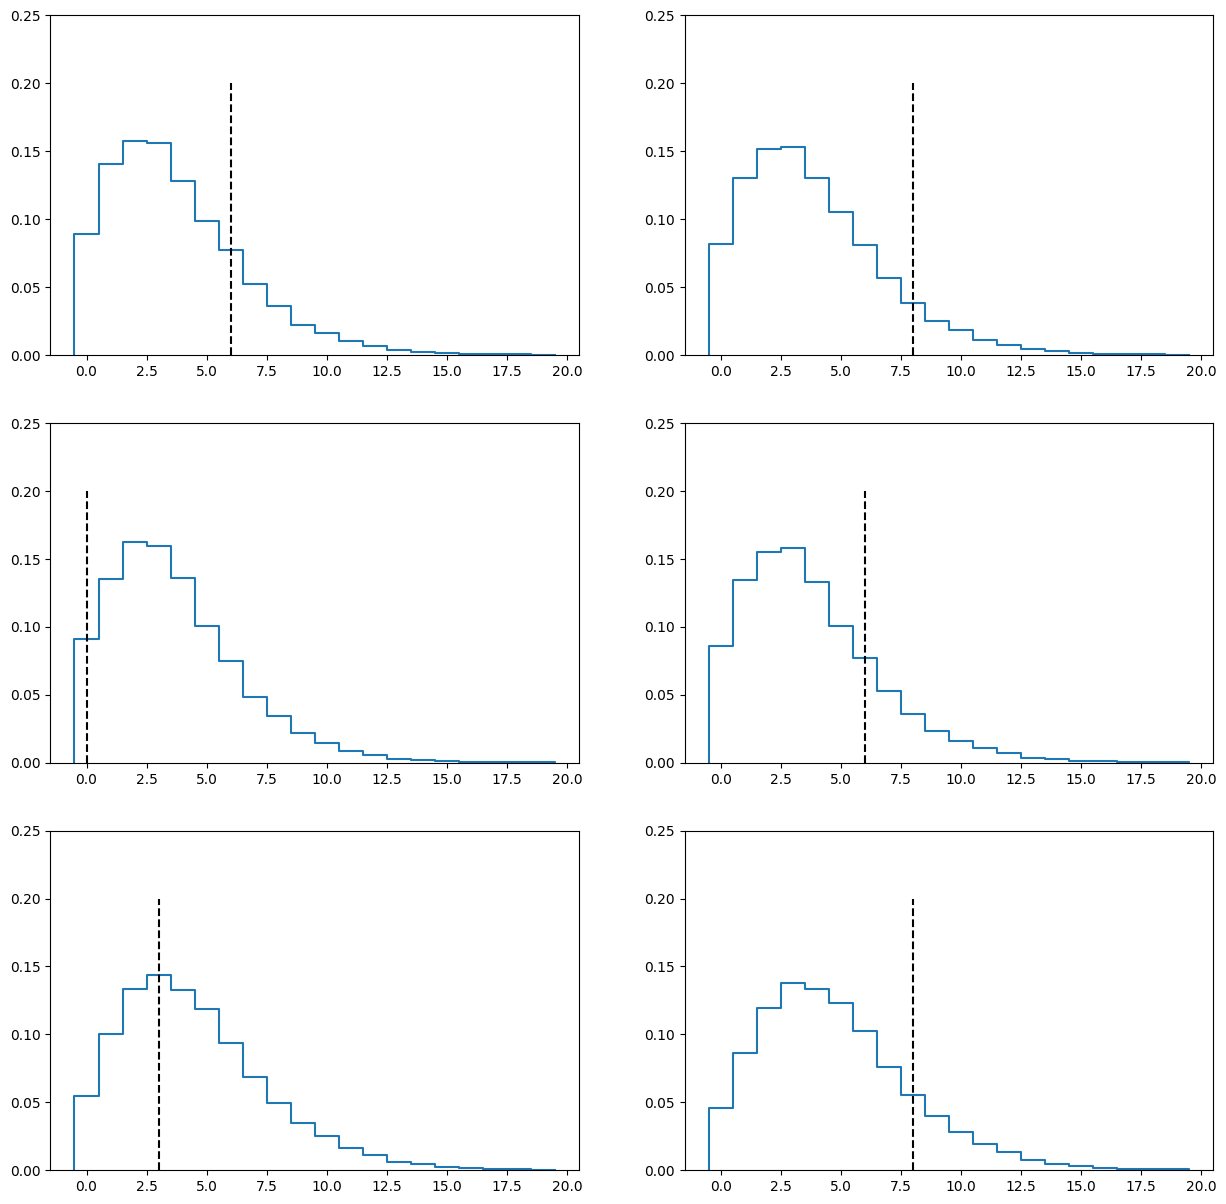

In [23]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    preds_test[i].plot_density()
    plt.ylim([0,.25])
    plt.vlines(x=y_test[i], ymin=0,ymax=.2, color='k', linestyle='--')

Next Steps

    - Using these probability distributions, we can now predict the distribution of total number of runs scored (by adding together the two distributions)

    - Using that, we can come up with probabilities on whether the total number of runs exceeds the over/under line